# This file is used for exploring the data

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist
import math
import sqlite3

In [2]:
# Read in the data
courses = pd.read_csv('data/courses.csv')
assessments = pd.read_csv('data/assessments.csv')
vle = pd.read_csv('data/vle.csv')
students = pd.read_csv('data/studentInfo.csv')
student_registration = pd.read_csv('data/studentRegistration.csv')
student_assessments = pd.read_csv('data/studentAssessment.csv')
student_vle = pd.read_csv('data/studentVle.csv')

con = sqlite3.connect("data/ou.db")
cur = con.cursor()

In [3]:
test_assessments = student_assessments.copy(deep=True)

def add_time_before_deadline():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['time_before_deadline'] = joined_assessments['date_submitted'] - joined_assessments['date']
    
def drop_banked():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['is_banked'] = joined_assessments['is_banked']
    test_assessments = test_assessments[student_assessments.is_banked == 0]
    
def add_assessment_info():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['weight'] = joined_assessments['weight']
    test_assessments['TMA'] = joined_assessments['assessment_type'] == "TMA"
    test_assessments['Exam'] = joined_assessments['assessment_type'] == "Exam"
    test_assessments['CMA'] = joined_assessments['assessment_type'] == "CMA"

def add_previous_average():
    global test_assessments
    # Use a sqlite database to make some calculations a lot quicker
    cur.execute('''
    SELECT (SELECT AVG(score)
        FROM assessments
                 JOIN student_assessments ON assessments.id_assessment = assessments.id_assessment AND
                                             student_assessments.id_student = sa.id_student
        WHERE date < a.date
          AND code_module = a.code_module
          AND assessments.code_presentation = a.code_presentation)
FROM assessments a
         JOIN student_assessments sa ON a.id_assessment = sa.id_assessment;
         ''')
    test_assessments['prev_avg'] = pd.DataFrame(cur.fetchall(), columns=['avg'])['avg']

def add_student_info():
    global test_assessments
    test_assessments = pd.merge(test_assessments, students, on='id_student')
    
# One hot encoding for assessment type
add_time_before_deadline()
drop_banked()
add_assessment_info()
add_previous_average()
add_student_info()

test_assessments.head()

,id_assessment,id_student,date_submitted,is_banked,score,time_before_deadline,weight,TMA,Exam,CMA,...,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,1752,11391,18,0,78.0,-1.0,10.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,1753,11391,53,0,85.0,-1.0,20.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
2,1754,11391,115,0,80.0,-2.0,20.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
3,1755,11391,164,0,85.0,-2.0,20.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
4,1756,11391,212,0,82.0,-3.0,30.0,True,False,False,...,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass


In [4]:
# May require --NotebookApp.iopub_data_rate_limit=1.0e10 jupyter parameter
def find_clicks():
    global test_assessments
    cur.execute('''
    SELECT COUNT(DISTINCT(student_vle.date)) AS days_worked_on_assessment,
       SUM(student_vle.sum_click)     AS total_clicks_for_assessment,
       MIN(student_vle.date) - a.date AS days_started_before_assessment,
       student_vle.id_student,
       student_vle.id_assessment
FROM student_vle
         LEFT JOIN assessments a ON student_vle.id_assessment = a.id_assessment
         LEFT JOIN student_assessments sa
                   ON student_vle.id_assessment = sa.id_assessment AND student_vle.id_student = sa.id_student
    WHERE student_vle.id_assessment IS NOT NULL
GROUP BY student_vle.id_assessment, student_vle.id_student''')
    info = pd.DataFrame(cur.fetchall(), columns=['days_worked_on_assessment', 'total_clicks_for_assessment', 'days_started_before_assessment', 'id_student', 'id_assessment'])
    print(len(info))
    test_assessments = pd.merge(test_assessments, info, on=['id_student', 'id_assessment'])
find_clicks()

141062


,id_assessment,id_student,date_submitted,is_banked,score,time_before_deadline,weight,TMA,Exam,CMA,...,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,days_worked_on_assessment,total_clicks_for_assessment,days_started_before_assessment
0,1753,11391,53,0,85.0,-1.0,20.0,True,False,False,...,HE Qualification,90-100%,55<=,0,240,N,Pass,18,529,-59.0
1,1754,11391,115,0,80.0,-2.0,20.0,True,False,False,...,HE Qualification,90-100%,55<=,0,240,N,Pass,8,99,-52.0
2,1755,11391,164,0,85.0,-2.0,20.0,True,False,False,...,HE Qualification,90-100%,55<=,0,240,N,Pass,5,85,-45.0
3,1756,11391,212,0,82.0,-3.0,30.0,True,False,False,...,HE Qualification,90-100%,55<=,0,240,N,Pass,3,78,-33.0
4,1753,28400,52,0,68.0,-2.0,20.0,True,False,False,...,HE Qualification,20-30%,35-55,0,60,N,Pass,26,669,-64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142509,37437,692171,168,0,65.0,-5.0,0.0,False,False,True,...,Lower Than A Level,20-30%,0-35,0,30,N,Pass,13,149,-45.0
142510,37438,692171,123,0,100.0,-106.0,0.0,False,False,True,...,Lower Than A Level,20-30%,0-35,0,30,N,Pass,7,192,-41.0
142511,37437,650630,177,0,55.0,4.0,0.0,False,False,True,...,Lower Than A Level,30-40%,35-55,0,30,N,Fail,2,17,-37.0
142512,37438,650630,189,0,80.0,-40.0,0.0,False,False,True,...,Lower Than A Level,30-40%,35-55,0,30,N,Fail,15,329,-54.0


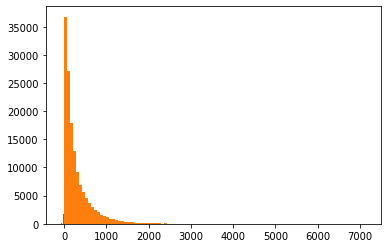

In [5]:
hist(test_assessments.days_worked_on_assessment, bins=100)
hist(test_assessments.total_clicks_for_assessment, bins=100)
hist(test_assessments.days_started_before_assessment, bins=100)
test_assessments

84092


,time_before_deadline,weight,prev_avg,studied_credits,days_worked_on_assessment,total_clicks_for_assessment,days_started_before_assessment
0,-1.0,20.0,77.2,240,18,529,-59.0
1,-2.0,20.0,64.2,240,8,99,-52.0
2,-2.0,20.0,82.0,240,5,85,-45.0
3,-3.0,30.0,65.8,240,3,78,-33.0
4,-2.0,20.0,60.4,60,26,669,-64.0


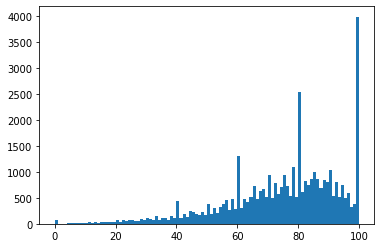

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
qt = QuantileTransformer()
test_assessments = test_assessments.dropna()
# 100 and 80 needs to be dealt with, too many of them
#test_assessments = test_assessments[test_assessments.score != 100]
#test_assessments = test_assessments[test_assessments.score != 80]
dropped = test_assessments.drop(["id_assessment", "id_student", "is_banked", "date_submitted", "gender", "region", 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result', 'code_module', 'code_presentation', 'num_of_prev_attempts'], axis=1)
#dropped = dropped.drop(["prev_avg"], axis=1)
dropped = dropped.drop(["TMA", "Exam", "CMA"], axis=1)
X = dropped.drop(['score'], axis=1)
y = dropped.score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.333)
print(len(X_train))
hist(y_test, bins=100)
X.head()

[-0.06030787 -0.13472408  0.14561503 -0.02484722  0.47827325  0.00101113
  0.16295062]
17.98833177428942
24.421606186776756
[-0.06030787 -0.13472407  0.14561502 -0.02484722  0.47827306  0.00101113
  0.16295056]
17.98833177634536
[-0.058363   -0.13148122  0.1399006  -0.02366235  0.4393691   0.00157951
  0.14820685]
17.99060616233177
[0.10564248 0.07851201 0.23402453 0.0739467  0.14032426 0.22642125
 0.14112877]
10.238439406161575
Best model test error: 10.252544246851443


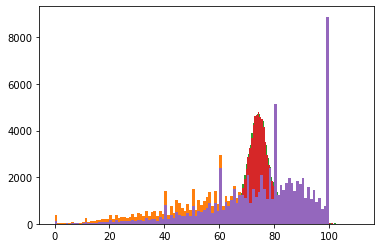

In [66]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

models = [
    LinearRegression(),
    KNeighborsClassifier(),
    Ridge(),
    Lasso(),
    #MLPClassifier(),
    RandomForestClassifier(random_state=0)
]

best_corr = None
best_error = 100
best = None

for model in models:
    model.fit(X_train, y_train)
    try:
        best_corr = model.coef_
        print(model.coef_)
    except Exception as e:
        pass
    try:
        best_corr = model.feature_importances_
        print(model.feature_importances_)
    except Exception as e:
        pass
    y_prediction = model.predict(X_val)
    error = np.sqrt(mean_squared_error(y_val, y_prediction))
    if error < best_error:
        best_error = error
        best = model
    print(error)
    hist(y_prediction, bins=100)

y_prediction = best.predict(X_test)
print(f"Best model test error: {np.sqrt(mean_squared_error(y_test, y_prediction))}")

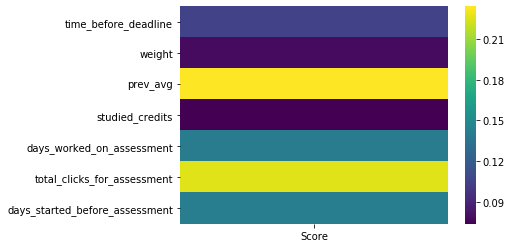

In [67]:
import seaborn as sns
ax = sns.heatmap(
    pd.DataFrame({"Score": best_corr}, index=X_test.columns), 
    #vmin=-1, vmax=1, center=0,
    cmap="viridis",
    fmt="g"
)